# Homework 5 - Yelp Data Analysis

In this notebook, we will work on two tasks. 
1. Predicting restaurant's rating 
2. Predicting Whether an Establishment has shut down

In [47]:
import pandas as pd
from collections import Counter
import numpy as np
import ast

# reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# pip install imblearn


import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pdpbox.pdp import pdp_isolate, pdp_plot

%matplotlib inline

## Part I. Data Exploration

The first step in performing a succesfull analysis is properly exploring our data. Below I have started by using pandas built in info() function to get some stats about all of the metrics in our data.

In [48]:
df_union = pd.read_csv("business_unfold.csv", low_memory=False)
print(df_union.shape)

(192609, 54)


In [49]:
# select columns with less than 75% of missing values

columns = df_union.columns
marked_for_removal = []
good_to_keep = []
for column in columns:
    temp = df_union[column]
    temp_describe = temp.isnull().describe()
    if temp_describe['top'] == True and temp_describe['freq'] > (temp_describe['count']*.75):
        marked_for_removal.append(column)
    else:
        good_to_keep.append(column)
        print(column + " is good to keep! Less than 75% of its values are null-objects.")
print('('+ str(len(good_to_keep)) + ') columns are good to keep')
print('\n\n')
for column in marked_for_removal:
    print(column + " is marked for removal")
print('('+ str(len(marked_for_removal)) + ') columns have been marked for removal')
    

Unnamed: 0 is good to keep! Less than 75% of its values are null-objects.
address is good to keep! Less than 75% of its values are null-objects.
business_id is good to keep! Less than 75% of its values are null-objects.
categories is good to keep! Less than 75% of its values are null-objects.
city is good to keep! Less than 75% of its values are null-objects.
hours is good to keep! Less than 75% of its values are null-objects.
is_open is good to keep! Less than 75% of its values are null-objects.
latitude is good to keep! Less than 75% of its values are null-objects.
longitude is good to keep! Less than 75% of its values are null-objects.
name is good to keep! Less than 75% of its values are null-objects.
postal_code is good to keep! Less than 75% of its values are null-objects.
review_count is good to keep! Less than 75% of its values are null-objects.
stars is good to keep! Less than 75% of its values are null-objects.
state is good to keep! Less than 75% of its values are null-objec

The columns that have been marked for removal must now be removed from the data

In [50]:
#dropping the columns that have been marked for removal
df = df_union.drop(marked_for_removal, axis=1)
for i in list(df.columns):
    print(i)

Unnamed: 0
address
business_id
categories
city
hours
is_open
latitude
longitude
name
postal_code
review_count
stars
state
businessID
Alcohol
BikeParking
BusinessAcceptsCreditCards
BusinessParking
GoodForKids
OutdoorSeating
RestaurantsAttire
RestaurantsDelivery
RestaurantsGoodForGroups
RestaurantsPriceRange2
RestaurantsReservations
RestaurantsTakeOut
WiFi


In [51]:
# from the above list, only keep the columns you are interested.

# latitude: a geographic coordinate that specifies the north–south position of a point on the Earth's surface
# longitude: a geographic coordinate that specifies the east–west position of a point on the Earth's surface
# review_count: the total number of reviews made on a business
# stars: the avg star rating for a business
# RestaurantsPriceRange2: the price range of a business ranging from 1-4
# HasBikeParking: binary variable denoting whether a restaurant has bike parking or not
# AcceptsCreditCards: a binary variable denoting whether a restaurant accepts credit cards or not

keeplist = ['is_open','latitude','longitude','review_count','stars','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']
df = df[keeplist].dropna()

In [52]:
# print the information of the dataset
print(df.info())

# print # of rows, # of columns
print(df.shape)

# print the first five rows
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 2 to 192603
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     22970 non-null  int64  
 1   latitude                    22970 non-null  float64
 2   longitude                   22970 non-null  float64
 3   review_count                22970 non-null  int64  
 4   stars                       22970 non-null  float64
 5   Alcohol                     22970 non-null  object 
 6   BikeParking                 22970 non-null  object 
 7   BusinessAcceptsCreditCards  22970 non-null  object 
 8   OutdoorSeating              22970 non-null  object 
 9   GoodForKids                 22970 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 1.9+ MB
None
(22970, 10)


,is_open,latitude,longitude,review_count,stars,Alcohol,BikeParking,BusinessAcceptsCreditCards,OutdoorSeating,GoodForKids
2,1,35.092564,-80.859132,170,4.0,u'beer_and_wine',True,True,False,True
12,1,35.527410,-80.868003,9,3.5,'beer_and_wine',True,True,True,False
13,1,41.708520,-81.359556,16,4.0,u'none',True,True,False,True
22,1,36.080168,-115.182756,107,4.0,u'full_bar',False,True,True,False
25,1,36.195615,-115.040529,184,4.5,u'beer_and_wine',True,True,False,True


# Part II. Data Cleansing

Here we will convert text variables to numeric variable variables

### Clean up the 'Alcohol' column

In [53]:
df['Alcohol'].value_counts()

u'none'             7626
u'full_bar'         6788
'none'              3475
u'beer_and_wine'    2183
'full_bar'          1873
'beer_and_wine'     1006
None                  19
Name: Alcohol, dtype: int64

In [54]:
df.loc[df["Alcohol"] == "u'none'", "Alcohol"] = 0 
df.loc[df["Alcohol"] == "'none'", "Alcohol"] = 0
df.loc[df["Alcohol"] == "None", "Alcohol"] = 0

df.loc[df["Alcohol"] == "u'beer_and_wine'", "Alcohol"] = 1
df.loc[df["Alcohol"] == "'beer_and_wine'", "Alcohol"] = 1

df.loc[df["Alcohol"] == "u'full_bar'", "Alcohol"] = 2
df.loc[df["Alcohol"] == "'full_bar'", "Alcohol"] = 2

In [55]:
df['Alcohol'] = df['Alcohol'].astype(int)
df['Alcohol'].value_counts()

0    11120
2     8661
1     3189
Name: Alcohol, dtype: int64

### Clean up other columns

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 2 to 192603
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     22970 non-null  int64  
 1   latitude                    22970 non-null  float64
 2   longitude                   22970 non-null  float64
 3   review_count                22970 non-null  int64  
 4   stars                       22970 non-null  float64
 5   Alcohol                     22970 non-null  int32  
 6   BikeParking                 22970 non-null  object 
 7   BusinessAcceptsCreditCards  22970 non-null  object 
 8   OutdoorSeating              22970 non-null  object 
 9   GoodForKids                 22970 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 1.8+ MB


In [57]:
# BikeParking
df['BikeParking'].value_counts()

True     17501
False     5447
None        22
Name: BikeParking, dtype: int64

In [58]:
df.loc[df["BikeParking"] == "True", "BikeParking"] = 1 
df.loc[df["BikeParking"] == "False", "BikeParking"] = 0
df.loc[df["BikeParking"] == "None", "BikeParking"] = 0

df['BikeParking'] = df['BikeParking'].astype(int)
df['BikeParking'].value_counts()

1    17501
0     5469
Name: BikeParking, dtype: int64

In [59]:
# BusinessAcceptsCreditCards
df['BusinessAcceptsCreditCards'].value_counts()

True     22489
False      466
None        15
Name: BusinessAcceptsCreditCards, dtype: int64

In [60]:
df.loc[df["BusinessAcceptsCreditCards"] == "True", "BusinessAcceptsCreditCards"] = 1 
df.loc[df["BusinessAcceptsCreditCards"] == "False", "BusinessAcceptsCreditCards"] = 0
df.loc[df["BusinessAcceptsCreditCards"] == "None", "BusinessAcceptsCreditCards"] = 0

df['BusinessAcceptsCreditCards'] = df['BusinessAcceptsCreditCards'].astype(int)
df['BusinessAcceptsCreditCards'].value_counts()

1    22489
0      481
Name: BusinessAcceptsCreditCards, dtype: int64

In [ ]:
# Task #1: change non-numeric values in the columns of 'OutdoorSeating','GoodForKids' to numeric values



## Part III. Model 1_Predictive Restaurant’s Rating (Regression)

In [43]:
x_columns = ['latitude','longitude','review_count','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']
# plot the distribution of 'stars'

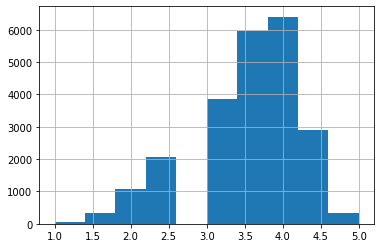

In [39]:
df['stars'].hist()

# if the distribution is too skewed, you might want to log-transform 'stars'.
# df['stars'] = np.log(df['stars'])

In [44]:
# split the dataset to train and test
X = df[x_columns]
y = df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

In [ ]:
# Task #2: build a Random Forest Regressor model





In [ ]:
# Task #3: plot the features importance scores




In [ ]:
# Task #4: create three pdpbox plots to explain the impact of 'review_count', 'Alcohol' on 'stars' separately.
# Also, interpret the pdpbox plots.

In [ ]:
# Task #5: Measure model performance using RMSE

from sklearn.metrics import mean_squared_error






## Part IV. Model 2_Predictive Restaurant’s Longevity (Classification)

In this part, we will build up a classification model, in which 'is_open' is the dependent variable (y).

1    18634
0     4336
Name: is_open, dtype: int64

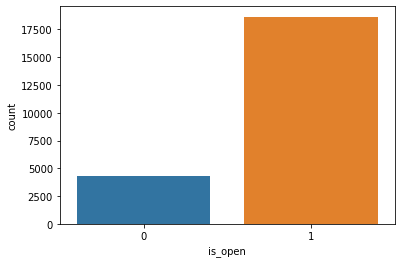

In [41]:
# Plot the distribution of the y variable
sns.countplot(df.is_open, label="Count")
df['is_open'].value_counts()

In [61]:
x_columns = ['latitude','longitude','review_count','stars','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']

In [68]:
# SMOTE: Synthetic Minority Oversampling Technique (synthesize new examples from the minority class)
from imblearn.over_sampling import (SMOTE)

sampler = SMOTE(sampling_strategy = 1)
X_rs, y_rs = sampler.fit_sample(df[x_columns], df['is_open'])
print('SMOTE {}'.format(Counter(y_rs)))

X=pd.DataFrame(X_rs, columns=x_columns)
y = pd.DataFrame(y_rs, columns = ['is_open'])

# combine the columns in X and y
df_new = pd.concat([X, y], axis=1)

SMOTE Counter({1: 18634, 0: 18634})


1    18634
0    18634
Name: is_open, dtype: int64

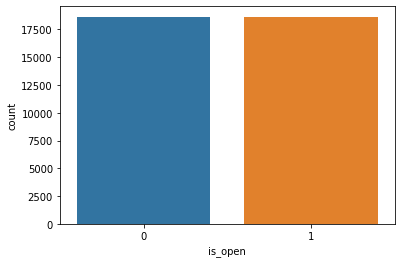

In [69]:
# Plot the distribution of the y variable
sns.countplot(df_new.is_open, label="Count")
df_new['is_open'].value_counts()

In [ ]:
# split the dataset for cross validation
X_train, X_test, y_train, y_test = train_test_split\
  (X, y, train_size = 0.6, random_state = 1)

In [ ]:
# Task #6: Create a Random Forest Classifier model 






In [ ]:
# Task #7: plot the features importance scores





In [ ]:
# Task #8: create three pdpbox plots to explain the impact of 'stars', 'review_count', 'Alcohol' on 'is_open' separately.
# Also, interpret the pdpbox plots.